<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "MOp-L6-IT-Sulf1"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/MOp/L6-IT-Sulf1/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

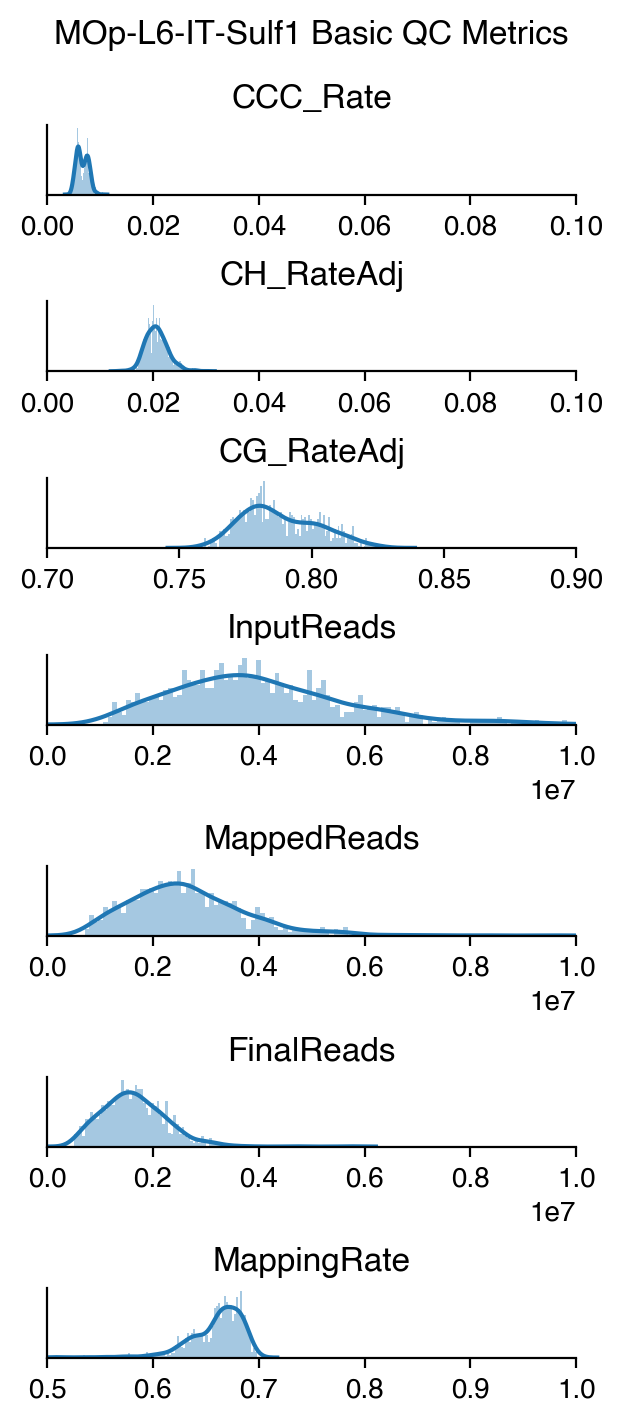

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

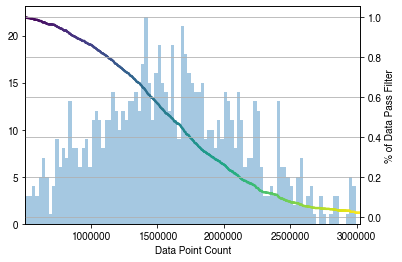

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 881/881 (100.0%)
CG_RateAdj passed 881/881 (100.0%)
CH_RateAdj passed 881/881 (100.0%)
FinalReads passed 881/881 (100.0%)
MappingRate passed 881/881 (100.0%)
Overall passed 881/881 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 137
171207 128
171212 31
171213 124
180104 120
180409 26
180410 30
180605 147
180612 138


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 104 27.1%
ad002 98 25.5%
ad004 115 29.9%
ad006 119 31.0%
ad007 100 26.0%
ad008 123 32.0%
ad010 123 32.0%
ad012 99 25.8%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter,consensus_cluster_rescued_anno
index,,,,,,,,,,,,,,,,,,,,,
2C_M_1015,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00576,0.79056,0.78935,0.02450,0.01885,1532059.0,3232414,2207753.0,2C,...,G10,CEMBA180409-2C-4,9,6,18,13,180409,2,True,L6-IT-Sulf1
2C_M_1039,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00603,0.77399,0.77262,0.02581,0.01990,2163544.0,5255018,3589538.0,2C,...,G2,CEMBA180409-2C-4,1,6,2,13,180409,2,True,L6-IT-Sulf1
2C_M_1049,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00599,0.77276,0.77139,0.02792,0.02206,563456.0,1281566,870424.0,2C,...,G4,CEMBA180409-2C-3,3,6,6,12,180409,2,True,L6-IT-Sulf1
2C_M_112,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00605,0.77691,0.77555,0.02609,0.02016,2271048.0,5237752,3564862.0,2C,...,B3,CEMBA180409-2C-1,2,1,5,3,180409,2,True,L6-IT-Sulf1
2C_M_1121,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180409_2C...,0.00565,0.77295,0.77166,0.02594,0.02041,1443249.0,3069830,2101982.0,2C,...,H3,CEMBA180409-2C-4,2,7,4,14,180409,2,True,L6-IT-Sulf1
2C_M_1200,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00595,0.77464,0.77329,0.02772,0.02190,1912833.0,4263246,2913116.0,2C,...,A4,CEMBA180410-2C-2,3,0,6,1,180410,2,True,L6-IT-Sulf1
2C_M_1249,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00616,0.79544,0.79417,0.02777,0.02174,2211498.0,5099374,3415310.0,2C,...,B1,CEMBA180410-2C-1,0,1,1,3,180410,2,True,L6-IT-Sulf1
2C_M_1280,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00720,0.78746,0.78592,0.03511,0.02811,2052472.0,4989294,3439920.0,2C,...,B5,CEMBA180410-2C-2,4,1,9,3,180410,2,True,L6-IT-Sulf1
2C_M_1286,/gale/raidix/rdx-4/CEMBA_RS1/2C/CEMBA180410_2C...,0.00569,0.78475,0.78352,0.02686,0.02129,884025.0,2065796,1367400.0,2C,...,B7,CEMBA180410-2C-1,6,1,12,2,180410,2,True,L6-IT-Sulf1
